In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

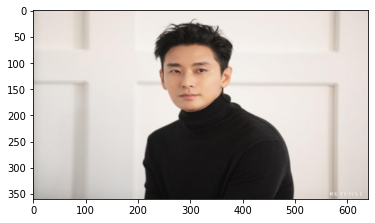

In [10]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/joo3.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)


#### Step2: 얼굴 검출 - face detection

rectangles[[(247, 80) (354, 187)]]


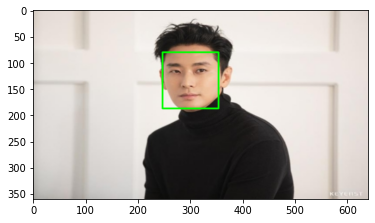

In [11]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 랜드마크 검출

68


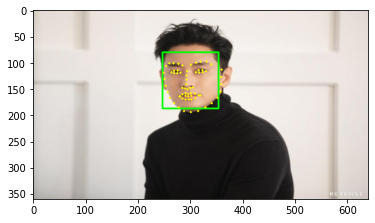

In [12]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### dlib를 이용해서 얼굴의 bounding box 위치, landmark 위치?

In [13]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] + dlib_rect.width()//2
    w = w = dlib_rect.width()
    h = h = dlib_rect.width()  #dlib_rect.width() 
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(292, 141)
(x,y) : (292,195)
(w,h) : (108,108)


코의 중심의 위치가 (292, 141)으로 나온다

In [14]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(108, 108, 3)


왕관 이미지를 읽고 윗 단계에서 계산한 크기로 resize 한다. 그리고 나서 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정한다.

In [15]:
refined_x = x - w // 2  # left
refined_y = y - h     # refined_y = y - h       # top

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (238,87)


y의 좌표가 음수가 나오는 이유는 이미지 밖의 스티커를 제외해야 하기 때문이다.   
따라서 범위 밖의 스티커가 제외되는 결과, 스티커의 사이즈가 조정된다.

### sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다. 예제에서는 (566,0) 부터 (566+268, 0+157) 범위의 이미지를 의미합니다.

스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용합니다. 따라서 np.where를 통해 img_sticker 가 0 인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_sticker를 사용하시면 됩니다. img_show 에 다시 적용하겠습니다.

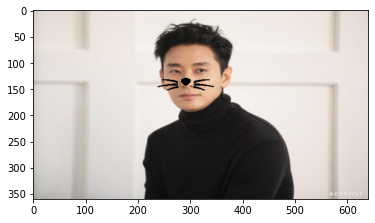

In [16]:
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()